In [32]:
import pickle
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score, confusion_matrix
import matplotlib.colors as mcolors

import matplotlib.pyplot as plt

In [2]:
epsilon = 1e-7

In [3]:
model_name_list = ['Prior', 'LR', 'SVC', 'RF', 'INN', 'NBC', 'MLP']

In [4]:
round_precision = 4
# dtype_dict = {'binary_crossentropy': float, 'brier_score': float, 'accuracy': float, 'TN': int, 'TP': int, 'FN': int, 'FP': int}

In [5]:
with open('../data/data_test.pt', 'rb') as file:
    X_test, y_test = pickle.load(file)

print(f'{X_test.shape = }')
print(f'{y_test.shape = }')

X_test.shape = (578417, 33)
y_test.shape = (578417, 2)


In [6]:
y_pred = {}
for model_name in model_name_list:
    if model_name == 'MLP':
        y_pred[model_name] = {}
        # clip for numerical stability
        y_pred_mlp = np.load('./predictions/MLP.npy').clip(epsilon, 1-epsilon)
        for i, y_label in enumerate(['hosp', 'death']):
                    y_pred[model_name][y_label] = np.concatenate([1 - y_pred_mlp[:, i].reshape(-1, 1), y_pred_mlp[:, i].reshape(-1, 1)], axis=1)
    else:
        with open(f'./predictions/{model_name}.pt', 'rb') as file:
            y_pred[model_name] = pickle.load(file)

            if model_name == 'NBC':
                for y_label in ['hosp', 'death']:
                    y_pred[model_name][y_label] = np.concatenate([1 - y_pred[model_name][y_label].reshape(-1, 1), y_pred[model_name][y_label].reshape(-1, 1)], axis=1)
        

In [7]:
for y_label in ['hosp', 'death']:
    y_pred['NBC'][y_label][np.isnan(y_pred['NBC'][y_label])] = 1 - y_test[np.isnan(y_pred['NBC'][y_label])]

In [8]:
results = {}

for i, y_label in enumerate(['hosp', 'death']):
    results[y_label] = {}
    
    for model_name in model_name_list:
        results[y_label][model_name] = {}

        # average performance over 5 runs
        if model_name in ['INN']:
            log_loss_list = [log_loss(y_test[:, i], y_pred[model_name][y_label][j][:, 1]) for j in range(5)]
            results[y_label][model_name]['binary_crossentropy'] = f'{np.mean(log_loss_list).round(round_precision)} ± {np.std(log_loss_list).round(round_precision)}'
            results[y_label][model_name]['binary_crossentropy_sortable'] = np.mean(log_loss_list).round(round_precision)

            brier_score_list = [brier_score_loss(y_test[:, i], y_pred[model_name][y_label][j][:, 1]) for j in range(5)]
            results[y_label][model_name]['brier_score'] = f'{np.mean(brier_score_list).round(round_precision)} ± {np.std(brier_score_list).round(round_precision)}'
            results[y_label][model_name]['brier_score_sortable'] = np.mean(brier_score_list).round(round_precision)

            accuracy_list = [accuracy_score(y_test[:, i], y_pred[model_name][y_label][j][:, 1].round()) for j in range(5)]
            results[y_label][model_name]['accuracy'] = f'{np.mean(accuracy_list).round(round_precision)} ± {np.std(accuracy_list).round(round_precision)}'
            results[y_label][model_name]['accuracy_sortable'] = np.mean(accuracy_list).round(round_precision)

            CMs = [confusion_matrix(y_test[:, i], (y_pred[model_name][y_label][j][:, 1] > 0.5).astype(int)) for j in range(5)]
            results[y_label][model_name]['TN'] = f'{np.mean([CMs[j][0, 0] for j in range(5)]).round(round_precision)} ± {np.std([CMs[j][0, 0] for j in range(5)]).round(0)}'
            results[y_label][model_name]['TP'] = f'{np.mean([CMs[j][1, 1] for j in range(5)]).round(round_precision)} ± {np.std([CMs[j][1, 1] for j in range(5)]).round(0)}'
            results[y_label][model_name]['FP'] = f'{np.mean([CMs[j][0, 1] for j in range(5)]).round(round_precision)} ± {np.std([CMs[j][0, 1] for j in range(5)]).round(0)}'
            results[y_label][model_name]['FN'] = f'{np.mean([CMs[j][1, 0] for j in range(5)]).round(round_precision)} ± {np.std([CMs[j][1, 0] for j in range(5)]).round(0)}'
        # training is deterministic, no need to average
        else:
            results[y_label][model_name]['binary_crossentropy'] = log_loss(y_test[:, i], y_pred[model_name][y_label][:, 1]).round(round_precision)
            results[y_label][model_name]['binary_crossentropy_sortable'] = log_loss(y_test[:, i], y_pred[model_name][y_label][:, 1]).round(round_precision)
            results[y_label][model_name]['brier_score'] = brier_score_loss(y_test[:, i], y_pred[model_name][y_label][:, 1]).round(round_precision)
            results[y_label][model_name]['brier_score_sortable'] = brier_score_loss(y_test[:, i], y_pred[model_name][y_label][:, 1]).round(round_precision)
            results[y_label][model_name]['accuracy'] = accuracy_score(y_test[:, i], y_pred[model_name][y_label][:, 1].round()).round(round_precision)
            results[y_label][model_name]['accuracy_sortable'] = accuracy_score(y_test[:, i], y_pred[model_name][y_label][:, 1].round()).round(round_precision)

            CM = confusion_matrix(y_test[:, i], (y_pred[model_name][y_label][:, 1] > 0.5).astype(int))
            results[y_label][model_name]['TN'] = CM[0, 0]
            results[y_label][model_name]['TP'] = CM[1, 1]
            results[y_label][model_name]['FP'] = CM[0, 1]
            results[y_label][model_name]['FN'] = CM[1, 0]

In [9]:
for y_label in ['hosp', 'death']:
    results[y_label]['Prior']['CPU'] = '-'
    results[y_label]['SVC']['CPU'] = 'i7-6700k(4C/8T)@4.5GHz'
    results[y_label]['RF']['CPU'] = 'i7-6700k(4C/8T)@4.5GHz'
    results[y_label]['LR']['CPU'] = 'i7-6700k(4C/8T)@4.5GHz'
    results[y_label]['INN']['CPU'] = 'i7-6700k(4C/8T)@4.5GHz'
    results[y_label]['NBC']['CPU'] = 'TODO'
    results[y_label]['MLP']['CPU'] = 'TODO'
    # results[y_label]['LGBM']['CPU'] = 'TODO'

    results[y_label]['Prior']['GPU'] = '-'
    results[y_label]['SVC']['GPU'] = '-'
    results[y_label]['RF']['GPU'] = '-'
    results[y_label]['LR']['GPU'] = '-'
    results[y_label]['INN']['GPU'] = 'GTX980Ti@1353/7010MHz'
    results[y_label]['NBC']['GPU'] = '-'
    results[y_label]['MLP']['GPU'] = 'TODO'
    # results[y_label]['LGBM']['GPU'] = 'TODO'

    results[y_label]['Prior']['Time (HH:mm)'] = '-'
    results[y_label]['SVC']['Time (HH:mm)'] = '00:45'
    results[y_label]['RF']['Time (HH:mm)'] = '02:00'
    results[y_label]['LR']['Time (HH:mm)'] = '03:00'
    results[y_label]['INN']['Time (HH:mm)'] = '26:00'
    results[y_label]['NBC']['Time (HH:mm)'] = 'TODO'
    results[y_label]['MLP']['Time (HH:mm)'] = 'TODO'
    # results[y_label]['LGBM']['Time (HH:mm)'] = 'TODO'

# Results

## Hospitalization

In [10]:
pd.DataFrame(results['hosp']).T.sort_values('binary_crossentropy_sortable').drop(columns=['binary_crossentropy_sortable', 'brier_score_sortable', 'accuracy_sortable'])

,binary_crossentropy,brier_score,accuracy,TN,TP,FP,FN,CPU,GPU,Time (HH:mm)
MLP,0.1924,0.0517,0.9378,537495,4968,1527,34427,TODO,TODO,TODO
SVC,0.208,0.0558,0.9342,538632,1736,390,37659,i7-6700k(4C/8T)@4.5GHz,-,00:45
INN,0.2369 ± 0.022,0.0607 ± 0.0034,0.9279 ± 0.0048,532827.4 ± 3774.0,3899.8 ± 1093.0,6194.6 ± 3774.0,35495.2 ± 1093.0,i7-6700k(4C/8T)@4.5GHz,GTX980Ti@1353/7010MHz,26:00
Prior,0.2487,0.0635,0.9319,539022,0,0,39395,-,-,-
RF,0.3544,0.0529,0.9371,535926,6102,3096,33293,i7-6700k(4C/8T)@4.5GHz,-,02:00
LR,0.391,0.1039,0.9274,529932,6520,9090,32875,i7-6700k(4C/8T)@4.5GHz,-,03:00
NBC,0.4768,0.0715,0.919,526654,4916,12368,34479,TODO,-,TODO


## Fatality

In [11]:
pd.DataFrame(results['death']).T.sort_values('binary_crossentropy_sortable').drop(columns=['binary_crossentropy_sortable', 'brier_score_sortable', 'accuracy_sortable'])

,binary_crossentropy,brier_score,accuracy,TN,TP,FP,FN,CPU,GPU,Time (HH:mm)
MLP,0.0338,0.0091,0.9895,570619,1727,80,5991,TODO,TODO,TODO
RF,0.0346,0.0087,0.9895,570438,1928,261,5790,i7-6700k(4C/8T)@4.5GHz,-,02:00
SVC,0.0416,0.0105,0.9883,570466,1204,233,6514,i7-6700k(4C/8T)@4.5GHz,-,00:45
LR,0.0513,0.0106,0.9884,570686,1022,13,6696,i7-6700k(4C/8T)@4.5GHz,-,03:00
INN,0.0631 ± 0.0067,0.012 ± 0.0009,0.9865 ± 0.0013,569106.8 ± 878.0,1476.0 ± 128.0,1592.2 ± 878.0,6242.0 ± 128.0,i7-6700k(4C/8T)@4.5GHz,GTX980Ti@1353/7010MHz,26:00
Prior,0.0709,0.0132,0.9867,570699,0,0,7718,-,-,-
NBC,0.3549,0.0244,0.9735,561083,2006,9616,5712,TODO,-,TODO


## Scatter bce vs brier for hosp and death

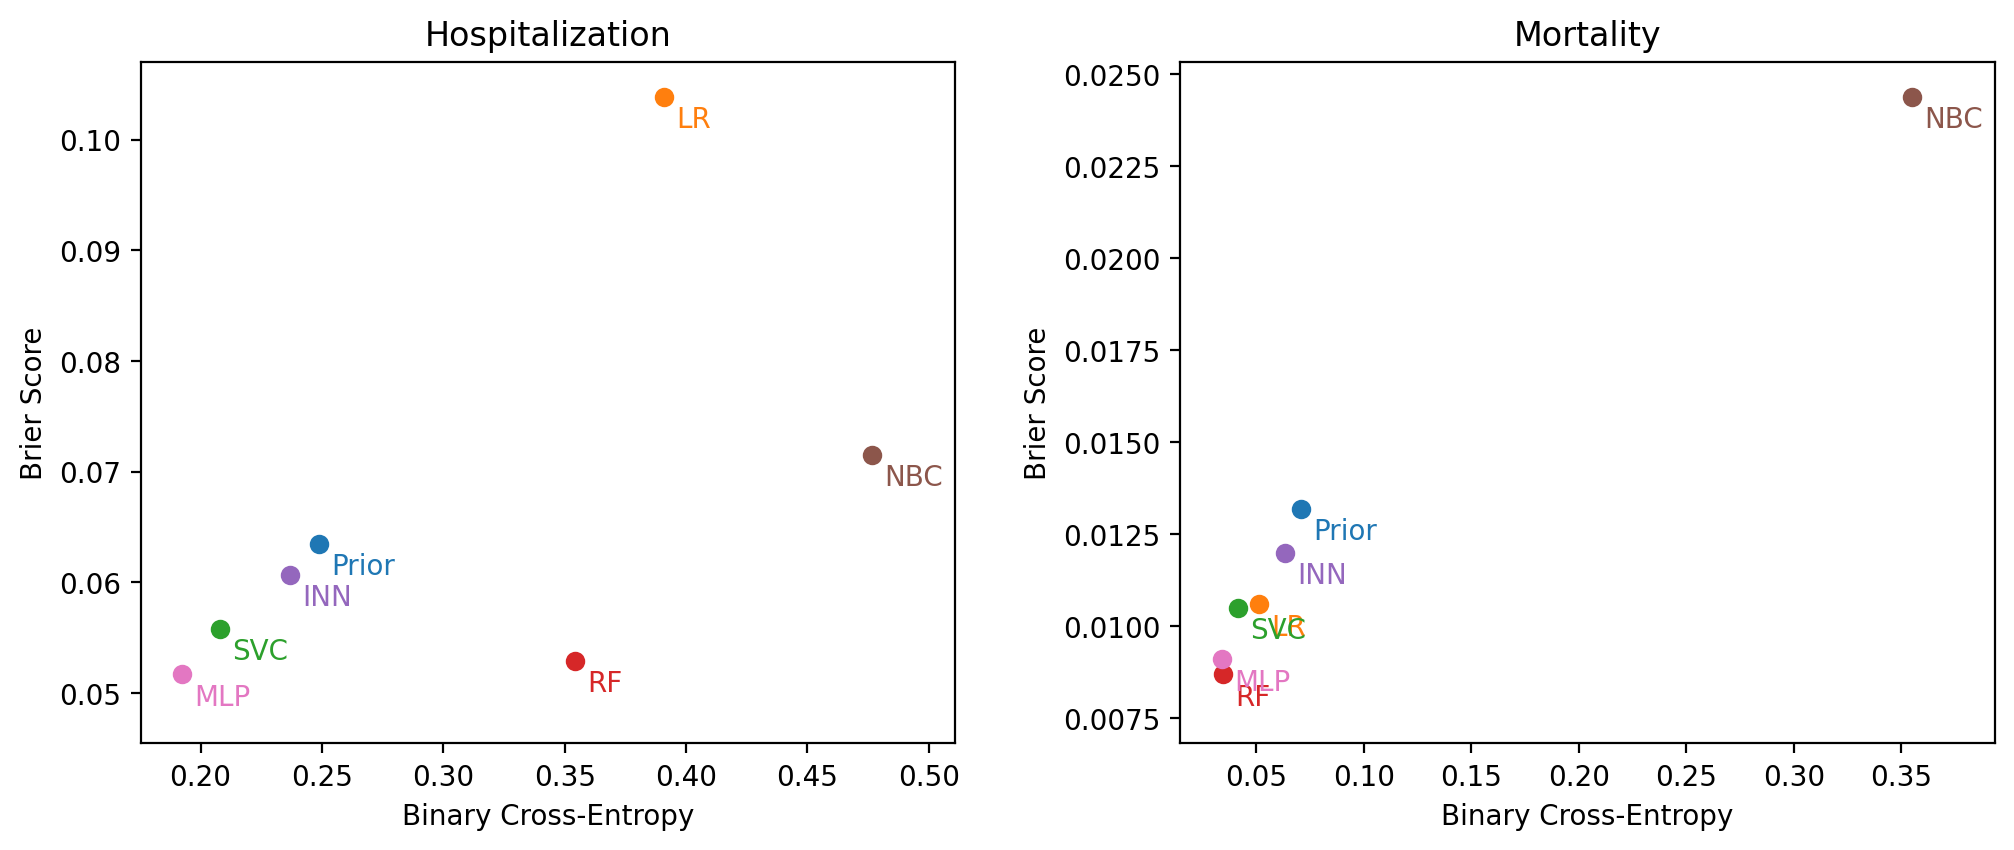

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(15/1.5, 6/1.5), dpi=200)

fig.tight_layout(w_pad=5)

for i, (y_label, y_label_detail) in enumerate(zip(['hosp', 'death'], ['Hospitalization', 'Mortality'])):
    x = np.array([results[y_label][model_name]['binary_crossentropy_sortable'] for model_name in model_name_list])
    y = np.array([results[y_label][model_name]['brier_score_sortable'] for model_name in model_name_list])

    x_linspace = np.linspace(x.min() - 0.06 * (x.max() - x.min()), x.max() + 0.12 * (x.max() - x.min()), 2)
    y_linspace = np.linspace(y.min() - 0.12 * (y.max() - y.min()), y.max() + 0.06 * (y.max() - y.min()), 2)

    xscaling = x_linspace.max() - x_linspace.min()
    yscaling = y_linspace.max() - y_linspace.min()
    
    # axes[i].plot(x_linspace, y_linspace, color='black', alpha=0.3, zorder=1, label='')
    
    for model_index, model_name, color in zip(range(len(x)), model_name_list, mcolors.TABLEAU_COLORS.keys()):
        axes[i].scatter(x[model_index], y[model_index], c=color, zorder=3)
        axes[i].annotate(model_name, (x[model_index] + 0.015 * xscaling, y[model_index] - 0.045 * yscaling), color=color)

    axes[i].set_xlim(x_linspace.min(), x_linspace.max())
    axes[i].set_ylim(y_linspace.min(), y_linspace.max())

    axes[i].set_title(y_label_detail)
    axes[i].set_xlabel('Binary Cross-Entropy')
    axes[i].set_ylabel('Brier Score')

## Scatter hosp vs death for bce breier acc

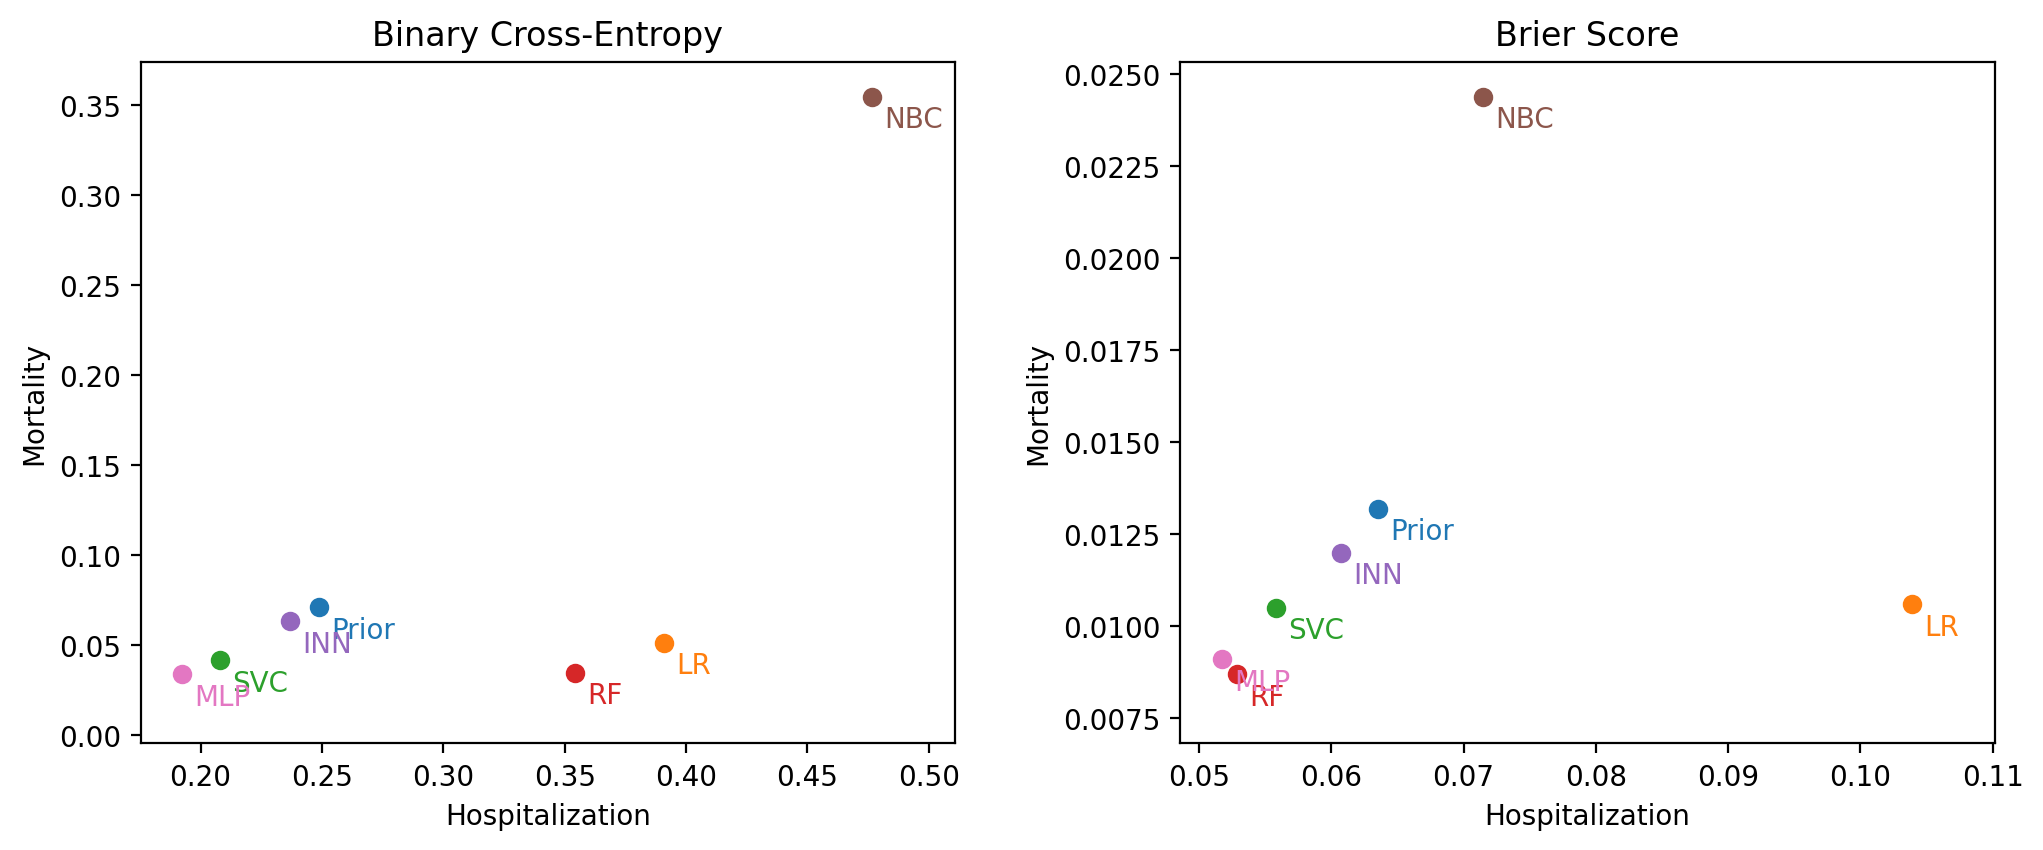

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(15/1.5, 6/1.5), dpi=200)

fig.tight_layout(w_pad=5)

for i, (metric_name, metric_name_detail) in enumerate(zip(['binary_crossentropy_sortable', 'brier_score_sortable'], ['Binary Cross-Entropy', 'Brier Score'])):
    x = np.array([results['hosp'][model_name][metric_name] for model_name in model_name_list])
    y = np.array([results['death'][model_name][metric_name] for model_name in model_name_list])

    x_linspace = np.linspace(x.min() - 0.06 * (x.max() - x.min()), x.max() + 0.12 * (x.max() - x.min()), 2)
    y_linspace = np.linspace(y.min() - 0.12 * (y.max() - y.min()), y.max() + 0.06 * (y.max() - y.min()), 2)

    xscaling = x_linspace.max() - x_linspace.min()
    yscaling = y_linspace.max() - y_linspace.min()
    
    # axes[i].plot(x_linspace, y_linspace, color='black', alpha=0.3, zorder=1, label='')
    
    for model_index, model_name, color in zip(range(len(x)), model_name_list, mcolors.TABLEAU_COLORS.keys()):
        axes[i].scatter(x[model_index], y[model_index], c=color, zorder=3)
        axes[i].annotate(model_name, (x[model_index] + 0.015 * xscaling, y[model_index] - 0.045 * yscaling), color=color)

    axes[i].set_xlim(x_linspace.min(), x_linspace.max())
    axes[i].set_ylim(y_linspace.min(), y_linspace.max())

    axes[i].set_title(metric_name_detail)
    axes[i].set_xlabel('Hospitalization')
    axes[i].set_ylabel('Mortality')